# Project: Wrangling and Analyze Data

In [1]:
import pandas as pd
import numpy as np
import json
import requests as r
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'figure.figsize':(12,8),
                     'font.size': 18,
                     'axes.labelsize': 18,
                     'axes.labelweight': 'bold',
                     'axes.titlesize': 22,
                     'axes.titleweight': 'bold'})

## Prepare CSV File

In [2]:
def txt_to_csv(txt_file, csv_file, lst_columns):
    data = []

    with open(txt_file, "r") as f:
        for line in f.readlines():
            line = json.loads(line)
            data.append(line)

    df = pd.DataFrame.from_records(data=data)
    df = df[lst_columns]
    df.to_csv(csv_file)

def get_data_from_url(url, file_name):
    try:
        response = r.get(url)
    except Exception as e:
        print(e)
    
    if response.status_code == 200:
        with open(file_name, "wb") as f:
            f.write(response.content)
    else:
        print(response.raise_for_status())

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [3]:
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [5]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
file_name = "image-predictions.tsv"

get_data_from_url(url, file_name)

img_predictions_df = pd.read_csv('image-predictions.tsv', sep='\t')

In [6]:
img_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [7]:
lst_columns = ["id", "favorite_count", "retweet_count"]
txt_to_csv(txt_file='tweet-json.txt', csv_file='tweet_data.csv', lst_columns=lst_columns)

In [8]:
tweet_additional_df = pd.read_csv('tweet_data.csv', index_col=0)
tweet_additional_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3)
memory usage: 73.6 KB


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



#### TWITTER ARCHIVE

In [9]:
twitter_archive_df.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None
1119,731285275100512256,NaN,NaN,2016-05-14 00:49:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Solomon. He's a Beneroo Cumberflop. 12...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731285275...,12,10,Solomon,None,None,None,None
926,754874841593970688,NaN,NaN,2016-07-18 03:06:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Rubio. He has too much ...,6.791584e+17,4.196984e+09,2015-12-22 04:35:49 +0000,https://twitter.com/dog_rates/status/679158373...,11,10,Rubio,None,None,None,None
965,750429297815552001,NaN,NaN,2016-07-05 20:41:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Arnie. He's a Nova Scotian Fridge Floo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750429297...,12,10,Arnie,None,None,None,None
2199,668779399630725120,NaN,NaN,2015-11-23 13:13:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kevon. He is not physically or mentall...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668779399...,10,10,Kevon,None,None,None,None
114,870656317836468226,NaN,NaN,2017-06-02 15:00:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cody. He zoomed too aggressively and t...,NaN,NaN,NaN,https://www.gofundme.com/help-fix-codys-torn-a...,13,10,Cody,None,None,None,None
1519,690735892932222976,NaN,NaN,2016-01-23 03:20:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Peaches. She's a Dingleberry Zand...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/690735892...,13,10,Peaches,None,None,None,None
1671,682393905736888321,NaN,NaN,2015-12-31 02:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kreg. He's riding an invisible jet ski...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682393905...,11,10,Kreg,None,None,None,None
881,760521673607086080,NaN,NaN,2016-08-02 17:04:31 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Doggo want what doggo cannot have. Temptation ...,NaN,NaN,NaN,https://vine.co/v/5ApKetxzmTB,12,10,None,doggo,None,None,None
2246,667878741721415682,NaN,NaN,2015-11-21 01:34:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tedrick. He lives on the edge. Needs s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667878741...,2,10,Tedrick,None,None,None,None


In [10]:
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
twitter_archive_df["source"].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [12]:
tweet_id_lst = twitter_archive_df[twitter_archive_df.tweet_id.notnull()]\
.retweeted_status_id\
.dropna()\
.unique()\
.tolist()

twitter_archive_df.query(f"retweeted_status_id in {tweet_id_lst}").retweeted_status_id.nunique()

181

In [13]:
twitter_archive_df.loc[twitter_archive_df.name.str.match(r'^[a-z]'), "name"].value_counts()

a               55
the              8
an               7
very             5
just             4
one              4
quite            4
mad              2
actually         2
not              2
getting          2
life             1
old              1
space            1
such             1
by               1
his              1
light            1
my               1
all              1
officially       1
unacceptable     1
infuriating      1
incredibly       1
this             1
Name: name, dtype: int64

In [14]:
twitter_archive_df["rating_numerator"].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [15]:
twitter_archive_df.query("rating_numerator == 50").text.values

array([ 'This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq'], dtype=object)

In [16]:
twitter_archive_df["rating_denominator"].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [17]:
twitter_archive_df.query("rating_denominator == 0").text.values

array([ "@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"], dtype=object)

#### IMAGE PREDICTIONS

In [18]:
img_predictions_df.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
640,681302363064414209,https://pbs.twimg.com/media/CXR44l9WcAAcG_N.jpg,1,frilled_lizard,0.326259,False,tailed_frog,0.104539,False,axolotl,0.072479,False
128,668274247790391296,https://pbs.twimg.com/media/CUYv4d2WUAAziXs.jpg,1,soft-coated_wheaten_terrier,0.406374,True,Lakeland_terrier,0.263854,True,toy_poodle,0.150844,True
1317,755206590534418437,https://pbs.twimg.com/media/CnsIT0WWcAAul8V.jpg,1,web_site,0.906673,False,printer,0.008600,False,carton,0.004533,False
954,705223444686888960,https://pbs.twimg.com/media/Ccl0-HVVAAAf8aK.jpg,1,Egyptian_cat,0.090508,False,Chesapeake_Bay_retriever,0.077373,True,Mexican_hairless,0.049472,True
907,700462010979500032,https://pbs.twimg.com/media/CbiKe7-W0AIVNNr.jpg,1,hamster,0.678651,False,Pomeranian,0.110268,True,Angora,0.104139,False
1583,796865951799083009,https://pbs.twimg.com/media/Cw8JWZ2UsAAJOZ6.jpg,1,Cardigan,0.839129,True,Boston_bull,0.080699,True,Pembroke,0.034505,True
1817,834086379323871233,https://pbs.twimg.com/media/C5NFIsjWQAEI93t.jpg,1,bath_towel,0.736759,False,sleeping_bag,0.062959,False,Labrador_retriever,0.045263,True
1284,750506206503038976,https://pbs.twimg.com/media/CmpVaOZWIAAp3z6.jpg,1,American_black_bear,0.219166,False,lesser_panda,0.214715,False,titi,0.091685,False
119,668171859951755264,https://pbs.twimg.com/media/CUXSwy8W4AA6uet.jpg,1,Chihuahua,0.664834,True,cowboy_boot,0.060343,False,giant_panda,0.059838,False
1803,832040443403784192,https://pbs.twimg.com/media/Cq9guJ5WgAADfpF.jpg,1,miniature_pinscher,0.796313,True,Chihuahua,0.155413,True,Staffordshire_bullterrier,0.030943,True


In [19]:
img_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
img_predictions_df.duplicated().sum()

0

In [21]:
img_predictions_df.tweet_id.duplicated().sum()

0

In [22]:
img_predictions_df.jpg_url.duplicated().sum()

66

In [23]:
img_no_id_df = img_predictions_df.drop("tweet_id", axis=1)
img_no_id_df.head()

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [24]:
img_no_id_df.duplicated().sum()

66

### Quality issues

**twitter_archive_df**

1. There are some records did not collect from Twitter

2. There is a rating denominator of 0 that is not a valid rating

3. There are some records are retweets instead of original tweet

4. There are some records are replies instead of original tweet

5. Column "name" contain some incorrect names

**img_predictions_df**

6. When we omit tweet_id, the other columns will have duplicate data

7. Columns "p1", "p2", and "p3" have inconsistent conventions for name data

8. The neural network was trained to classify dog breeds, but our data contains many other things

### Tidiness issues
1. Columns p1, p2 and p3 should combine to one most confident prediction column

2. The three data frames above should merge to one data frame

3. Some columns have no useful information

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [25]:
# Make copies of original pieces of data
twitter_archive_df_clone = twitter_archive_df.copy()
img_predictions_df_clone = img_predictions_df.copy()
tweet_additional_df_clone = tweet_additional_df.copy()

### Quality Issue:

### 1. There are some records did not collect from Twitter

#### Define: Extract href from column "source" and then drop any url doesn't contain twitter.com

#### Code

In [26]:
twitter_archive_df_clone.tweet_id.count()

2356

In [27]:
twitter_archive_df_clone[~twitter_archive_df_clone.source.str.contains("twitter.com")].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
529,808344865868283904,NaN,NaN,2016-12-12 16:16:49 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Seamus. He's very bad at entering pool...,NaN,NaN,NaN,https://vine.co/v/5QWd3LZqXxd,11,10,Seamus,None,None,None,None
562,802600418706604034,NaN,NaN,2016-11-26 19:50:26 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Bailey. She has mastered the head tilt...,NaN,NaN,NaN,https://vine.co/v/5FwUWjYaW0Y,11,10,Bailey,None,None,None,None
657,791774931465953280,NaN,NaN,2016-10-27 22:53:48 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Vine will be deeply missed. This was by far my...,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,14,10,None,None,None,None,None
672,789903600034189313,NaN,NaN,2016-10-22 18:57:48 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Ralphy. His dreams were just shattered...,NaN,NaN,NaN,https://vine.co/v/5wPT1aBxPQZ,13,10,Ralphy,None,None,pupper,None
699,786286427768250368,NaN,NaN,2016-10-12 19:24:27 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Arnie. He's afraid of his own bark. 12...,NaN,NaN,NaN,https://vine.co/v/5XH0WqHwiFp,12,10,Arnie,None,None,None,None


In [28]:
twitter_archive_df_clone = twitter_archive_df_clone[twitter_archive_df_clone.source.str.contains("twitter.com")]

#### Test

In [29]:
twitter_archive_df_clone.tweet_id.count()

2265

In [30]:
twitter_archive_df_clone[~twitter_archive_df_clone.source.str.contains("twitter.com")].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### 2. There is a rating denominator of 0 that is not a valid rating

#### Define: Filter any row which have column rating_denominator equal to 0 then drop them

#### Code

In [31]:
twitter_archive_df_clone.loc[twitter_archive_df_clone.rating_denominator == 0, "rating_denominator"].count()

1

In [32]:
twitter_archive_df_clone = twitter_archive_df_clone[twitter_archive_df_clone.rating_denominator != 0]

#### Test

In [33]:
twitter_archive_df_clone.loc[twitter_archive_df_clone.rating_denominator == 0, "rating_denominator"].count()

0

### 3. There are some records are retweets instead of original tweet

#### Define: Drop any row have retweet_status_id

#### Code

In [34]:
twitter_archive_df_clone[twitter_archive_df_clone.retweeted_status_id.notnull()].count()

tweet_id                      181
in_reply_to_status_id           0
in_reply_to_user_id             0
timestamp                     181
source                        181
text                          181
retweeted_status_id           181
retweeted_status_user_id      181
retweeted_status_timestamp    181
expanded_urls                 180
rating_numerator              181
rating_denominator            181
name                          181
doggo                         181
floofer                       181
pupper                        181
puppo                         181
dtype: int64

In [35]:
twitter_archive_df_clone = twitter_archive_df_clone[twitter_archive_df_clone.retweeted_status_id.isnull()]

#### Test

In [36]:
twitter_archive_df_clone[twitter_archive_df_clone.retweeted_status_id.notnull()].count()

tweet_id                      0
in_reply_to_status_id         0
in_reply_to_user_id           0
timestamp                     0
source                        0
text                          0
retweeted_status_id           0
retweeted_status_user_id      0
retweeted_status_timestamp    0
expanded_urls                 0
rating_numerator              0
rating_denominator            0
name                          0
doggo                         0
floofer                       0
pupper                        0
puppo                         0
dtype: int64

### 4. There are some records are retweets or replies instead of original tweet

#### Define:  Drop any row have in_reply_to_status_id

#### Code

In [37]:
twitter_archive_df_clone[twitter_archive_df_clone.in_reply_to_status_id.notnull()].count()

tweet_id                      77
in_reply_to_status_id         77
in_reply_to_user_id           77
timestamp                     77
source                        77
text                          77
retweeted_status_id            0
retweeted_status_user_id       0
retweeted_status_timestamp     0
expanded_urls                 23
rating_numerator              77
rating_denominator            77
name                          77
doggo                         77
floofer                       77
pupper                        77
puppo                         77
dtype: int64

In [38]:
twitter_archive_df_clone = twitter_archive_df_clone[twitter_archive_df_clone.in_reply_to_status_id.isnull()]

#### Test

In [39]:
twitter_archive_df_clone[twitter_archive_df_clone.in_reply_to_status_id.notnull()].count()

tweet_id                      0
in_reply_to_status_id         0
in_reply_to_user_id           0
timestamp                     0
source                        0
text                          0
retweeted_status_id           0
retweeted_status_user_id      0
retweeted_status_timestamp    0
expanded_urls                 0
rating_numerator              0
rating_denominator            0
name                          0
doggo                         0
floofer                       0
pupper                        0
puppo                         0
dtype: int64

### 5. Column "name" contain some incorrect names

#### Define: Extract name which isn't capitalize first letter from column "name" and then drop them

#### Code

In [40]:
twitter_archive_df_clone.loc[twitter_archive_df_clone.name.str.match(r'^[a-z]'), "name"].value_counts()

a               55
the              7
an               6
one              4
very             4
quite            3
just             3
getting          2
actually         2
not              2
his              1
by               1
such             1
space            1
light            1
my               1
all              1
officially       1
unacceptable     1
infuriating      1
incredibly       1
this             1
Name: name, dtype: int64

In [41]:
twitter_archive_df_clone = twitter_archive_df_clone[~twitter_archive_df_clone.name.str.match(r'^[a-z]')]

#### Test

In [42]:
twitter_archive_df_clone.loc[twitter_archive_df_clone.name.str.match(r'^[a-z]'), "name"].value_counts()

Series([], Name: name, dtype: int64)

### 6. When we omit tweet_id, the other columns will have duplicate data

#### Define: Drop duplicated data from column jpg_url

#### Code

In [43]:
img_predictions_df_clone.jpg_url.duplicated().sum()

66

In [44]:
img_predictions_df_clone.drop_duplicates("jpg_url", inplace=True)

#### Test

In [45]:
img_predictions_df_clone.jpg_url.duplicated().sum()

0

### 7. Columns "p1", "p2", and "p3" have inconsistent conventions for name data

#### Define: Split string by "\_"  and capitalize then join by " "

#### Code

In [46]:
img_predictions_df_clone[["p1", "p2", "p3"]].head()

,p1,p2,p3
0,Welsh_springer_spaniel,collie,Shetland_sheepdog
1,redbone,miniature_pinscher,Rhodesian_ridgeback
2,German_shepherd,malinois,bloodhound
3,Rhodesian_ridgeback,redbone,miniature_pinscher
4,miniature_pinscher,Rottweiler,Doberman


In [47]:
def capitalize_name(data):
    data = str(data)
    lst = data.split("_")
    lst = [name.capitalize() for name in lst]
    data = " ".join(lst)
    
    return data

In [48]:
img_predictions_df_clone["p1"] = img_predictions_df_clone.p1.apply(capitalize_name)
img_predictions_df_clone["p2"] = img_predictions_df_clone.p2.apply(capitalize_name)
img_predictions_df_clone["p3"] = img_predictions_df_clone.p3.apply(capitalize_name)

#### Test

In [49]:
img_predictions_df_clone[["p1", "p2", "p3"]].head()

,p1,p2,p3
0,Welsh Springer Spaniel,Collie,Shetland Sheepdog
1,Redbone,Miniature Pinscher,Rhodesian Ridgeback
2,German Shepherd,Malinois,Bloodhound
3,Rhodesian Ridgeback,Redbone,Miniature Pinscher
4,Miniature Pinscher,Rottweiler,Doberman


### 8. The neural network was trained to classify dog breeds, but our data contains many other things

#### Define: Drop any row have p1_dog and p2_dog and p3_dog are False

#### Code

In [50]:
img_predictions_df_clone[(img_predictions_df_clone.p1_dog | img_predictions_df_clone.p2_dog | img_predictions_df_clone.p3_dog) == False].count()

tweet_id    318
jpg_url     318
img_num     318
p1          318
p1_conf     318
p1_dog      318
p2          318
p2_conf     318
p2_dog      318
p3          318
p3_conf     318
p3_dog      318
dtype: int64

In [51]:
img_predictions_df_clone = img_predictions_df_clone[(img_predictions_df_clone.p1_dog | img_predictions_df_clone.p2_dog | img_predictions_df_clone.p3_dog) != False]

#### Test

In [52]:
img_predictions_df_clone[(img_predictions_df_clone.p1_dog | img_predictions_df_clone.p2_dog | img_predictions_df_clone.p3_dog) == False].count()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

### Tidiness Issue:

### 1. Columns p1, p2 and p3 should combine to one most confident prediction column

#### Define: Select value for most confident column by priority from p1 to p3 if its p_dog equal to True

#### Code

In [53]:
img_predictions_df_clone.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [54]:
conditions = [
    (img_predictions_df_clone['p1_dog'] == True),
    (img_predictions_df_clone['p2_dog'] == True),
    (img_predictions_df_clone['p3_dog'] == True)
]

values = [
    img_predictions_df_clone['p1'],
    img_predictions_df_clone['p2'],
    img_predictions_df_clone['p3']
]

img_predictions_df_clone['dog_breed'] = np.select(conditions, values)

#### Test

In [55]:
img_predictions_df_clone.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True,Welsh Springer Spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True,Redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True,German Shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True,Rhodesian Ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,Miniature Pinscher


### 2. The three data frames above should merge to one data frame

#### Define: Merge three dataframes to one dataframe

#### Code

In [56]:
twitter_full_df = twitter_archive_df_clone\
.merge(img_predictions_df_clone, how='inner', on='tweet_id')\
.merge(tweet_additional_df_clone, how='inner',
       left_on='tweet_id', right_on='id')\
.drop('id', axis=1)

#### Test

In [57]:
twitter_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586 entries, 0 to 1585
Data columns (total 31 columns):
tweet_id                      1586 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1586 non-null object
source                        1586 non-null object
text                          1586 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1586 non-null object
rating_numerator              1586 non-null int64
rating_denominator            1586 non-null int64
name                          1586 non-null object
doggo                         1586 non-null object
floofer                       1586 non-null object
pupper                        1586 non-null object
puppo                         1586 non-null object
jpg_url                       1586 non-n

### 3. Some columns have no useful information

#### Define: Drop columns have no useful information

#### Code

In [58]:
twitter_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586 entries, 0 to 1585
Data columns (total 31 columns):
tweet_id                      1586 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1586 non-null object
source                        1586 non-null object
text                          1586 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1586 non-null object
rating_numerator              1586 non-null int64
rating_denominator            1586 non-null int64
name                          1586 non-null object
doggo                         1586 non-null object
floofer                       1586 non-null object
pupper                        1586 non-null object
puppo                         1586 non-null object
jpg_url                       1586 non-n

In [59]:
columns_drop_lst = ["in_reply_to_status_id", "in_reply_to_user_id",
                    "retweeted_status_id", "retweeted_status_user_id",
                    "retweeted_status_timestamp",
                    "p1", "p1_conf", "p1_dog",
                    "p2", "p2_conf", "p2_dog",
                    "p3", "p3_conf", "p3_dog"]

twitter_full_df\
.drop(columns_drop_lst, axis=1, inplace=True)

#### Test

In [60]:
twitter_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586 entries, 0 to 1585
Data columns (total 17 columns):
tweet_id              1586 non-null int64
timestamp             1586 non-null object
source                1586 non-null object
text                  1586 non-null object
expanded_urls         1586 non-null object
rating_numerator      1586 non-null int64
rating_denominator    1586 non-null int64
name                  1586 non-null object
doggo                 1586 non-null object
floofer               1586 non-null object
pupper                1586 non-null object
puppo                 1586 non-null object
jpg_url               1586 non-null object
img_num               1586 non-null int64
dog_breed             1586 non-null object
favorite_count        1586 non-null int64
retweet_count         1586 non-null int64
dtypes: int64(6), object(11)
memory usage: 223.0+ KB


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [61]:
twitter_full_df.to_csv("twitter_archive_master.csv")

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [62]:
twitter_full_df.iloc[:,:8].head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name
0,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly
1,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie
2,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla
3,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin
4,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None


In [63]:
twitter_full_df.iloc[:,8:].head()

,doggo,floofer,pupper,puppo,jpg_url,img_num,dog_breed,favorite_count,retweet_count
0,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,33819,6514
1,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,25461,4328
2,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador Retriever,42908,8964
3,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,41048,9774
4,None,None,None,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake Bay Retriever,20562,3261


#### 1. Which breed of dog has the largest average of favorites and retweets?

In [64]:
top10_fav_breed = twitter_full_df[["dog_breed", "favorite_count", "retweet_count"]]\
.groupby("dog_breed").mean()\
.sort_values(by=["favorite_count", "retweet_count"],
             ascending=[False, False]).head(10)

top10_fav_breed

,favorite_count,retweet_count
dog_breed,,
Black-and-tan Coonhound,33911.000000,8285.000000
Saluki,24060.000000,5133.750000
Bedlington Terrier,21153.166667,7510.166667
French Bulldog,18416.806452,5039.677419
Bouvier Des Flandres,18032.000000,4479.000000
Afghan Hound,17326.666667,5976.000000
Flat-coated Retriever,16791.625000,4520.250000
Irish Water Spaniel,16400.000000,4500.666667
English Springer,15632.222222,5990.000000


#### Visualization

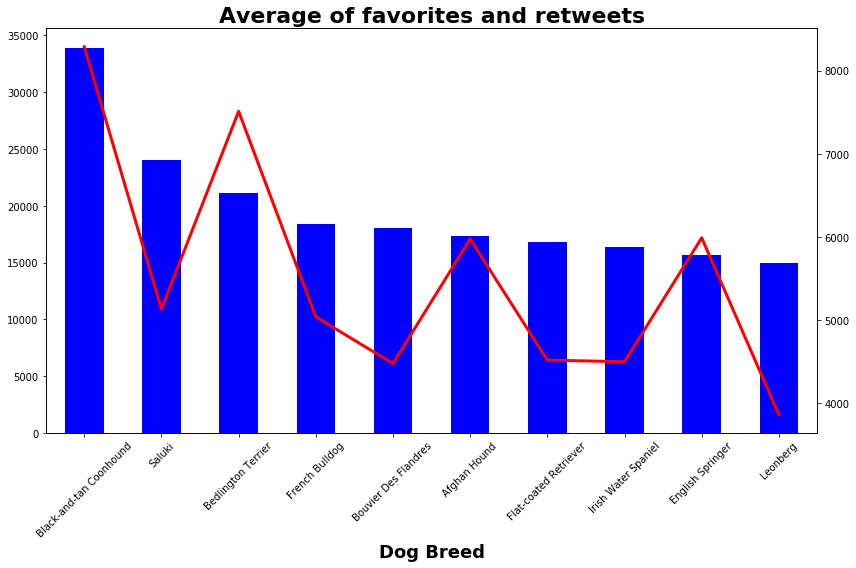

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))

top10_fav_breed.favorite_count.plot(kind='bar', color='b')
top10_fav_breed.retweet_count.plot(kind='line', linewidth=3,
                                   color='r', secondary_y=True)

ax.set_xticklabels(top10_fav_breed.index.tolist(), rotation=45)

plt.title("Average of favorites and retweets")
ax.set_xlabel('Dog Breed')
fig.tight_layout()
plt.show();

#### Insights:
- Black-and-tan Coonhound is the most favorite and most retweeted
- Saluki is the second favorite but has an average of retweets smaller than many other breeds of dog

#### 2. Determine the correlation between favorites and retweets?

In [66]:
fav_retweet_corr = twitter_full_df[["favorite_count", "retweet_count"]].corr()

In [67]:
fav_retweet_corr

,favorite_count,retweet_count
favorite_count,1.00000,0.91128
retweet_count,0.91128,1.00000


#### Visualization

In [76]:
fav_retweet = twitter_full_df[["dog_breed", "favorite_count", "retweet_count"]]\
.groupby("dog_breed").mean()

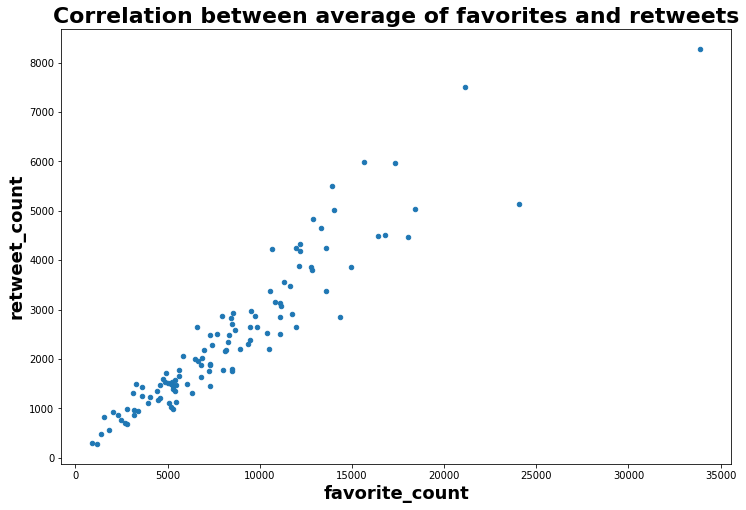

In [77]:
fav_retweet.plot(kind='scatter', x='favorite_count', y='retweet_count', figsize=(12,8))

plt.title("Correlation between average of favorites and retweets");

#### Insights:
- The relationship between number of favorites and retweets is strong correlation

#### 3. The most common breed of dog on the WeRateDogs Twitter?

In [70]:
top10_common_breed = twitter_full_df["dog_breed"]\
.value_counts()\
.head(10)

top10_common_breed

Golden Retriever      150
Labrador Retriever    103
Pembroke               90
Chihuahua              88
Pug                    58
Toy Poodle             46
Chow                   45
Samoyed                40
Pomeranian             38
French Bulldog         31
Name: dog_breed, dtype: int64

#### Visualization

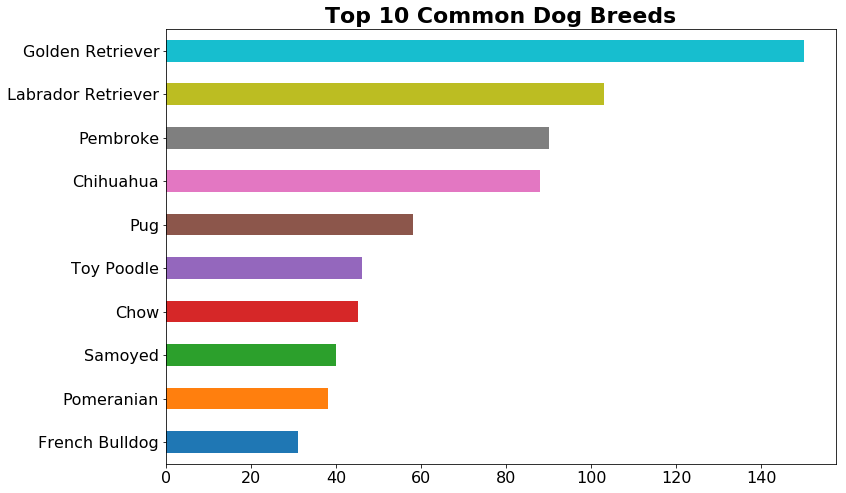

In [73]:
top10_common_breed.sort_values(ascending=True)\
.plot(kind='barh', figsize=(12,8), fontsize=16)

plt.title("Top 10 Common Dog Breeds");

#### Insights:
- Golden Retriever is the most common breed of dog on the WeRateDogs Twitter